# Here is Notebook 4: The Greenfield DCF Engine.

This is the core "calculator" of our project. It combines the construction pain (Notebook 2) with the operational gain (Notebook 3) to determine if the project is actually viable.

Key Insights from the J-Curve:

* The Valley of Death: You can visually see the massive hole dug during construction. In the "Reality" case, the project is $7.7 Billion in the hole before it generates its first dollar of revenue.

* The Payback Gap: "The Pitch" pays back in Year 12. "The Reality" pays back in Year 25. That 13-year gap is exactly why private equity rarely funds nuclear—it's too long to wait for a return of capital.

* Value Destruction: At an 8% discount rate, only the perfect "Pitch" scenario creates value. The "Reality" case destroys $2.4 Billion in value, suggesting that a commercially viable nuclear industry requires either lower capital costs (SMRs?), faster builds (learning curve?), or government financing (lower WACC).

Block 1: Setup & Helper Functions

We define our WACC (8%) and create functions to stitch together the cash flow timeline and calculate NPV/Payback.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import numpy_financial, if not available, define simple NPV function
try:
    import numpy_financial as npf
except ImportError:
    # Simple replacement for NPV
    class npf:
        @staticmethod
        def npv(rate, values):
            values = np.array(values)
            times = np.arange(len(values))
            return (values / (1 + rate) ** times).sum()

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 4: The Greenfield DCF Engine ---")

# 1. Load Data from Previous Notebooks
try:
    df_capex = pd.read_csv('capex_schedule.csv')
    df_ops = pd.read_csv('operational_economics.csv')
    print("CAPEX and Operational data loaded successfully.")
except FileNotFoundError:
    print("Error: Input files not found. Please run Notebooks 2 and 3.")

# 2. Define Financial Assumptions
DISCOUNT_RATE = 0.08 # 8% WACC for new build

print(f"Discount Rate (WACC): {DISCOUNT_RATE:.1%}")

# --- Function to Assemble Cash Flow ---
def assemble_cash_flows(capex_scenario_name, power_price_scenario):
    """
    Combines construction cash outflows and operational cash inflows into one timeline.
    """
    # 1. Get CAPEX (Construction Phase)
    # Filter for the specific construction scenario
    capex_data = df_capex[df_capex['Scenario_Name'] == capex_scenario_name].sort_values('Year_Index')

    # Cash Flows are negative (Outflows)
    const_years = capex_data['Year_Index'].values
    const_flows = -capex_data['Annual_Spend_M'].values

    construction_duration = len(const_years)

    # 2. Get OPEX/Revenue (Operational Phase)
    op_col = f'Op_CashFlow_M_{power_price_scenario}'
    ops_flows = df_ops[op_col].values
    ops_years = df_ops['Oper_Year'].values + construction_duration # Shift years to start after construction

    # 3. Combine
    all_years = np.concatenate([const_years, ops_years])
    all_flows = np.concatenate([const_flows, ops_flows])

    return all_years, all_flows

# --- Function to Calculate Metrics ---
def calculate_metrics(years, cash_flows):
    # NPV
    npv = npf.npv(DISCOUNT_RATE, cash_flows)

    # Payback Period (Simple)
    cum_cf = np.cumsum(cash_flows)
    # Find first year where cumulative CF > 0
    payback_idx = np.where(cum_cf > 0)[0]
    if len(payback_idx) > 0:
        payback_year = years[payback_idx[0]]
    else:
        payback_year = np.nan # Never pays back

    return npv, cum_cf, payback_year

print("Functions defined.")

--- Notebook 4: The Greenfield DCF Engine ---
CAPEX and Operational data loaded successfully.
Discount Rate (WACC): 8.0%
Functions defined.


Block 2: Running the Scenarios

We run the DCF for three distinct storylines: "The Pitch" (what investors are sold), "The Reality" (what history suggests), and "The Disaster" (what everyone fears).

In [18]:
print("Running DCF for Key Investment Cases...")

scenarios_to_run = [
    {
        'Name': 'The Pitch (Perfect World)',
        'Capex_Scenario': 'Low (China/Korea) / Brochure_Time',
        'Power_Scenario': 'Bull_Power',
        'Color': 'green'
    },
    {
        'Name': 'The Reality (Most Likely)',
        'Capex_Scenario': 'Med (France/UK) / Realistic_Time',
        'Power_Scenario': 'Base_Power',
        'Color': 'blue'
    },
    {
        'Name': 'The Disaster (Vogtle/Flamanville)',
        'Capex_Scenario': 'High (US/Vogtle) / Disaster_Time',
        'Power_Scenario': 'Bear_Power',
        'Color': 'red'
    }
]

results = []
curves = {}

for scen in scenarios_to_run:
    name = scen['Name']
    capex_name = scen['Capex_Scenario']
    power_name = scen['Power_Scenario']

    # Assemble Cash Flows
    years, flows = assemble_cash_flows(capex_name, power_name)

    # Calculate Metrics
    npv, cum_cf, payback = calculate_metrics(years, flows)

    # Store Results
    results.append({
        'Scenario': name,
        'NPV ($M)': npv,
        'Payback_Year': payback,
        'Peak_Deficit ($M)': cum_cf.min() # The bottom of the valley
    })

    # Store Curve for Plotting
    curves[name] = (years, cum_cf)

df_results = pd.DataFrame(results)

print("\n--- Greenfield DCF Results (WACC = 8%) ---")
print(df_results[['Scenario', 'NPV ($M)', 'Payback_Year', 'Peak_Deficit ($M)']])

Running DCF for Key Investment Cases...

--- Greenfield DCF Results (WACC = 8%) ---
                            Scenario     NPV ($M)  Payback_Year  \
0          The Pitch (Perfect World)  2557.471972            12   
1          The Reality (Most Likely) -2482.395300            25   
2  The Disaster (Vogtle/Flamanville) -6672.483605            60   

   Peak_Deficit ($M)  
0            -4400.0  
1            -7700.0  
2           -12100.0  


Block 3: Visualizing the Valley of Death

We plot the famous "J-Curve" which visually demonstrates the depth of the capital hole and the time required to climb out of it.

Visualizing the J-Curve (The Valley of Death)...


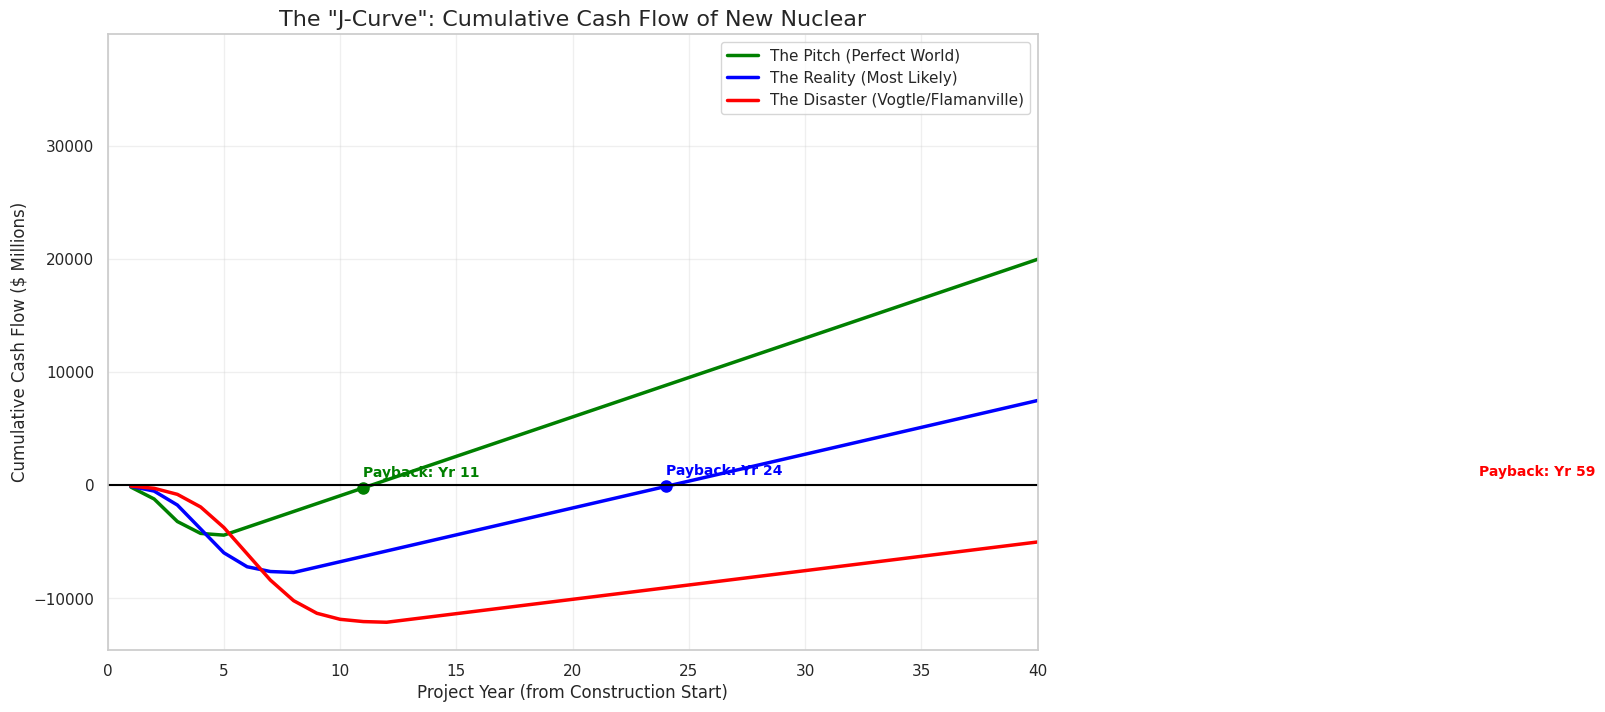

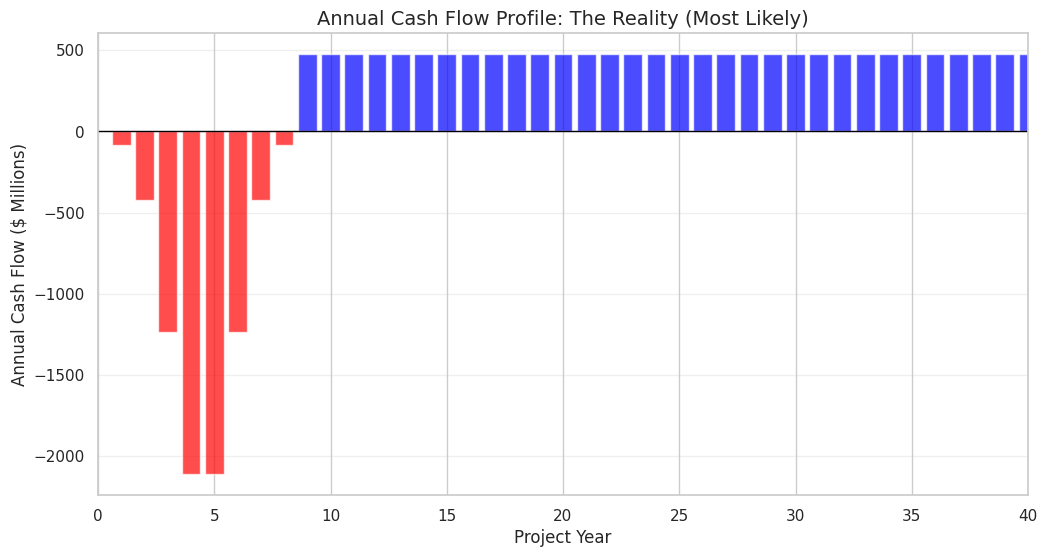

Greenfield Results saved to 'greenfield_results.csv'. Ready for Notebook 5.


In [21]:
print("Visualizing the J-Curve (The Valley of Death)...")

# 1. Plot: Cumulative Cash Flow (The J-Curve)
plt.figure(figsize=(12, 8))

for scen in scenarios_to_run:
    name = scen['Name']
    years, cum_cf = curves[name]
    color = scen['Color']

    plt.plot(years, cum_cf, label=name, color=color, linewidth=2.5)

    # Mark Payback Point
    # Find index where it crosses 0
    cross_idx = np.where(np.diff(np.sign(cum_cf)))[0]
    if len(cross_idx) > 0:
        idx = cross_idx[0]
        plt.plot(years[idx], cum_cf[idx], marker='o', color=color, markersize=8)
        plt.text(years[idx], cum_cf[idx]+1000, f"Payback: Yr {years[idx]}", color=color, fontsize=10, fontweight='bold')

plt.axhline(0, color='black', linewidth=1.5)
plt.title('The "J-Curve": Cumulative Cash Flow of New Nuclear', fontsize=16)
plt.ylabel('Cumulative Cash Flow ($ Millions)')
plt.xlabel('Project Year (from Construction Start)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 40) # Focus on the first 40 years
plt.show()

# 2. Plot: Annual Cash Flow Profile (For "The Reality" Case)
name_real = 'The Reality (Most Likely)'
# Re-run assemble for plotting
capex_name_real = 'Med (France/UK) / Realistic_Time'
power_name_real = 'Base_Power'
y_real, f_real = assemble_cash_flows(capex_name_real, power_name_real)

plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'blue' for x in f_real]
plt.bar(y_real, f_real, color=colors, alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.title(f'Annual Cash Flow Profile: {name_real}', fontsize=14)
plt.ylabel('Annual Cash Flow ($ Millions)')
plt.xlabel('Project Year')
plt.xlim(0, 40)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 3. Export Results
df_results.to_csv('greenfield_results.csv', index=False)
print("Greenfield Results saved to 'greenfield_results.csv'. Ready for Notebook 5.")